In [349]:
import math
from tqdm import tqdm
import pylab as plt
import numpy as np
import seaborn as snb

from scipy.stats import poisson
from scipy.stats import gamma

from exercise8 import compute_effective_sample_size
from exercise8 import compute_Rhat
from exercise8 import plot_summary
from exercise8 import metropolis


def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

# Model starts
data = np.load("./data_assignment3.npz")
X, t = data["x"], data["t"]

# Normal distribution
log_npdf = lambda x, m, v: -0.5*(x-m)**2/(v) - 0.5*np.log(2*np.pi*v)
npdf = lambda x, m, v: np.exp(log_npdf(x, m, v))

In [350]:
m_X = np.mean(X)
s_X = np.std(X)
standardize = lambda x: (x-m_X)/s_X
X = standardize(X)
    
X_train_pre = X[:, None]
t_train = t

# Let's set-up the design matrix for the training data and the inputs for predictions
design_matrix = lambda x: np.column_stack((np.ones(len(x)), x))
X_train = design_matrix(X_train_pre)

In [351]:
from scipy.stats import norm
def log_halfnormal(x):
    if x < 0: # negative values not supported
        return -np.Inf
    else:
        return np.log(2) + norm.logpdf(x, 0, 1)

In [352]:
def metropolis(log_joint, num_params, tau, num_iter, theta_init=None, seed=None):    
    """ Runs a Metropolis-Hastings sampler 
    
        Arguments:
        log_joint:          function for evaluating the log joint distribution
        num_params:         number of parameters of the joint distribution (integer)
        tau:                variance of Gaussian proposal distribution (positive real)
        num_iter:           number of iterations (integer)
        theta_init:         vector of initial parameters (np.array with shape (num_params) or None)        
        seed:               seed (integer or None)

        returns
        thetas              np.array with MCMC samples (np.array with shape (num_iter+1, num_params))
    """ 
    
    # prevent progress bar from causing issues
    if hasattr(tqdm,'_instances'):
        tqdm._instances.clear()
    
    if seed is not None:
        np.random.seed(seed)

    if theta_init is None:
        theta_init = np.zeros((num_params))
    
    # prepare lists 
    thetas = [theta_init]
    accepts = []
    log_p_theta = log_joint(theta_init)
    
    for k in tqdm(range(num_iter)):

        # get the last value for theta and generate new proposal candidate
        theta_cur = thetas[-1]
        theta_star = theta_cur + np.random.normal(0, tau, size=(num_params))
        
        # evaluate the log density for the candidate sample
        log_p_theta_star = log_joint(theta_star)

        # compute acceptance probability
        log_r = log_p_theta_star - log_p_theta
        A = min(1, np.exp(log_r))
        
        # accept new candidate with probability A
        if np.random.uniform() < A:
            theta_next = theta_star
            log_p_theta = log_p_theta_star
            accepts.append(1)
        else:
            theta_next = theta_cur
            accepts.append(0)

        thetas.append(theta_next)
        
    print('Acceptance ratio: %3.2f' % np.mean(accepts))
        
    thetas = np.stack(thetas)
    return thetas

In [375]:
#2.2
def marginalized_log_joint(theta):
    w_0 = np.array(theta[0:2])
    w_1 = np.array(theta[2:4])
    v = np.array(theta[4:6])
    tau_sqr = theta[6]**2
    sigma_0 = np.abs(theta[7])
    sigma_1 = np.abs(theta[8])
    
    # log prior
    log_prior_w_0 = np.sum(log_npdf(w_0, 0, tau_sqr))
    log_prior_w_1 = np.sum(log_npdf(w_1, 0, tau_sqr))
    log_prior_v = np.sum(log_npdf(v, 0, tau_sqr))
    log_prior_tau = log_halfnormal(tau_sqr)
    log_prior_sigma_0 = log_halfnormal(sigma_0)
    log_prior_sigma_1 = log_halfnormal(sigma_1)
    
    # log likelihood
    pi = sigmoid(X_train@v)
    pi_inv = np.ones(len(pi)) - pi
    
    y_0 = (X_train@w_0)
    y_1 = (X_train@w_1)

    log_likelihood_y0 = np.sum(log_npdf(t_train, y_0, sigma_0**2) * pi_inv)
    log_likelihood_y1 = np.sum(log_npdf(t_train, y_1, sigma_1**2) * pi)
    return (log_likelihood_y0 + log_likelihood_y1 + log_prior_w_0 + log_prior_w_1 + log_prior_v + log_prior_tau + log_prior_sigma_0 + log_prior_sigma_1)

tau = 0.25
num_iter = 100000
warm_up = int(0.2*num_iter)
num_params = 9

init = [1,1, 1,1, 1,1 , 1, 1, 1]
mixture_reg = metropolis(marginalized_log_joint, num_params, tau, theta_init=init, num_iter=num_iter)

# get rid of warm-up samples
mixture_reg = mixture_reg[warm_up:, :]

  0%|                                                | 0/100000 [00:00<?, ?it/s]/var/folders/w9/94vqs82s3gq0qywpffjb890w0000gn/T/ipykernel_32179/3754982718.py:42: RuntimeWarning: overflow encountered in exp
  A = min(1, np.exp(log_r))
100%|█████████████████████████████████| 100000/100000 [01:07<00:00, 1482.85it/s]


Acceptance ratio: 0.12


In [383]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

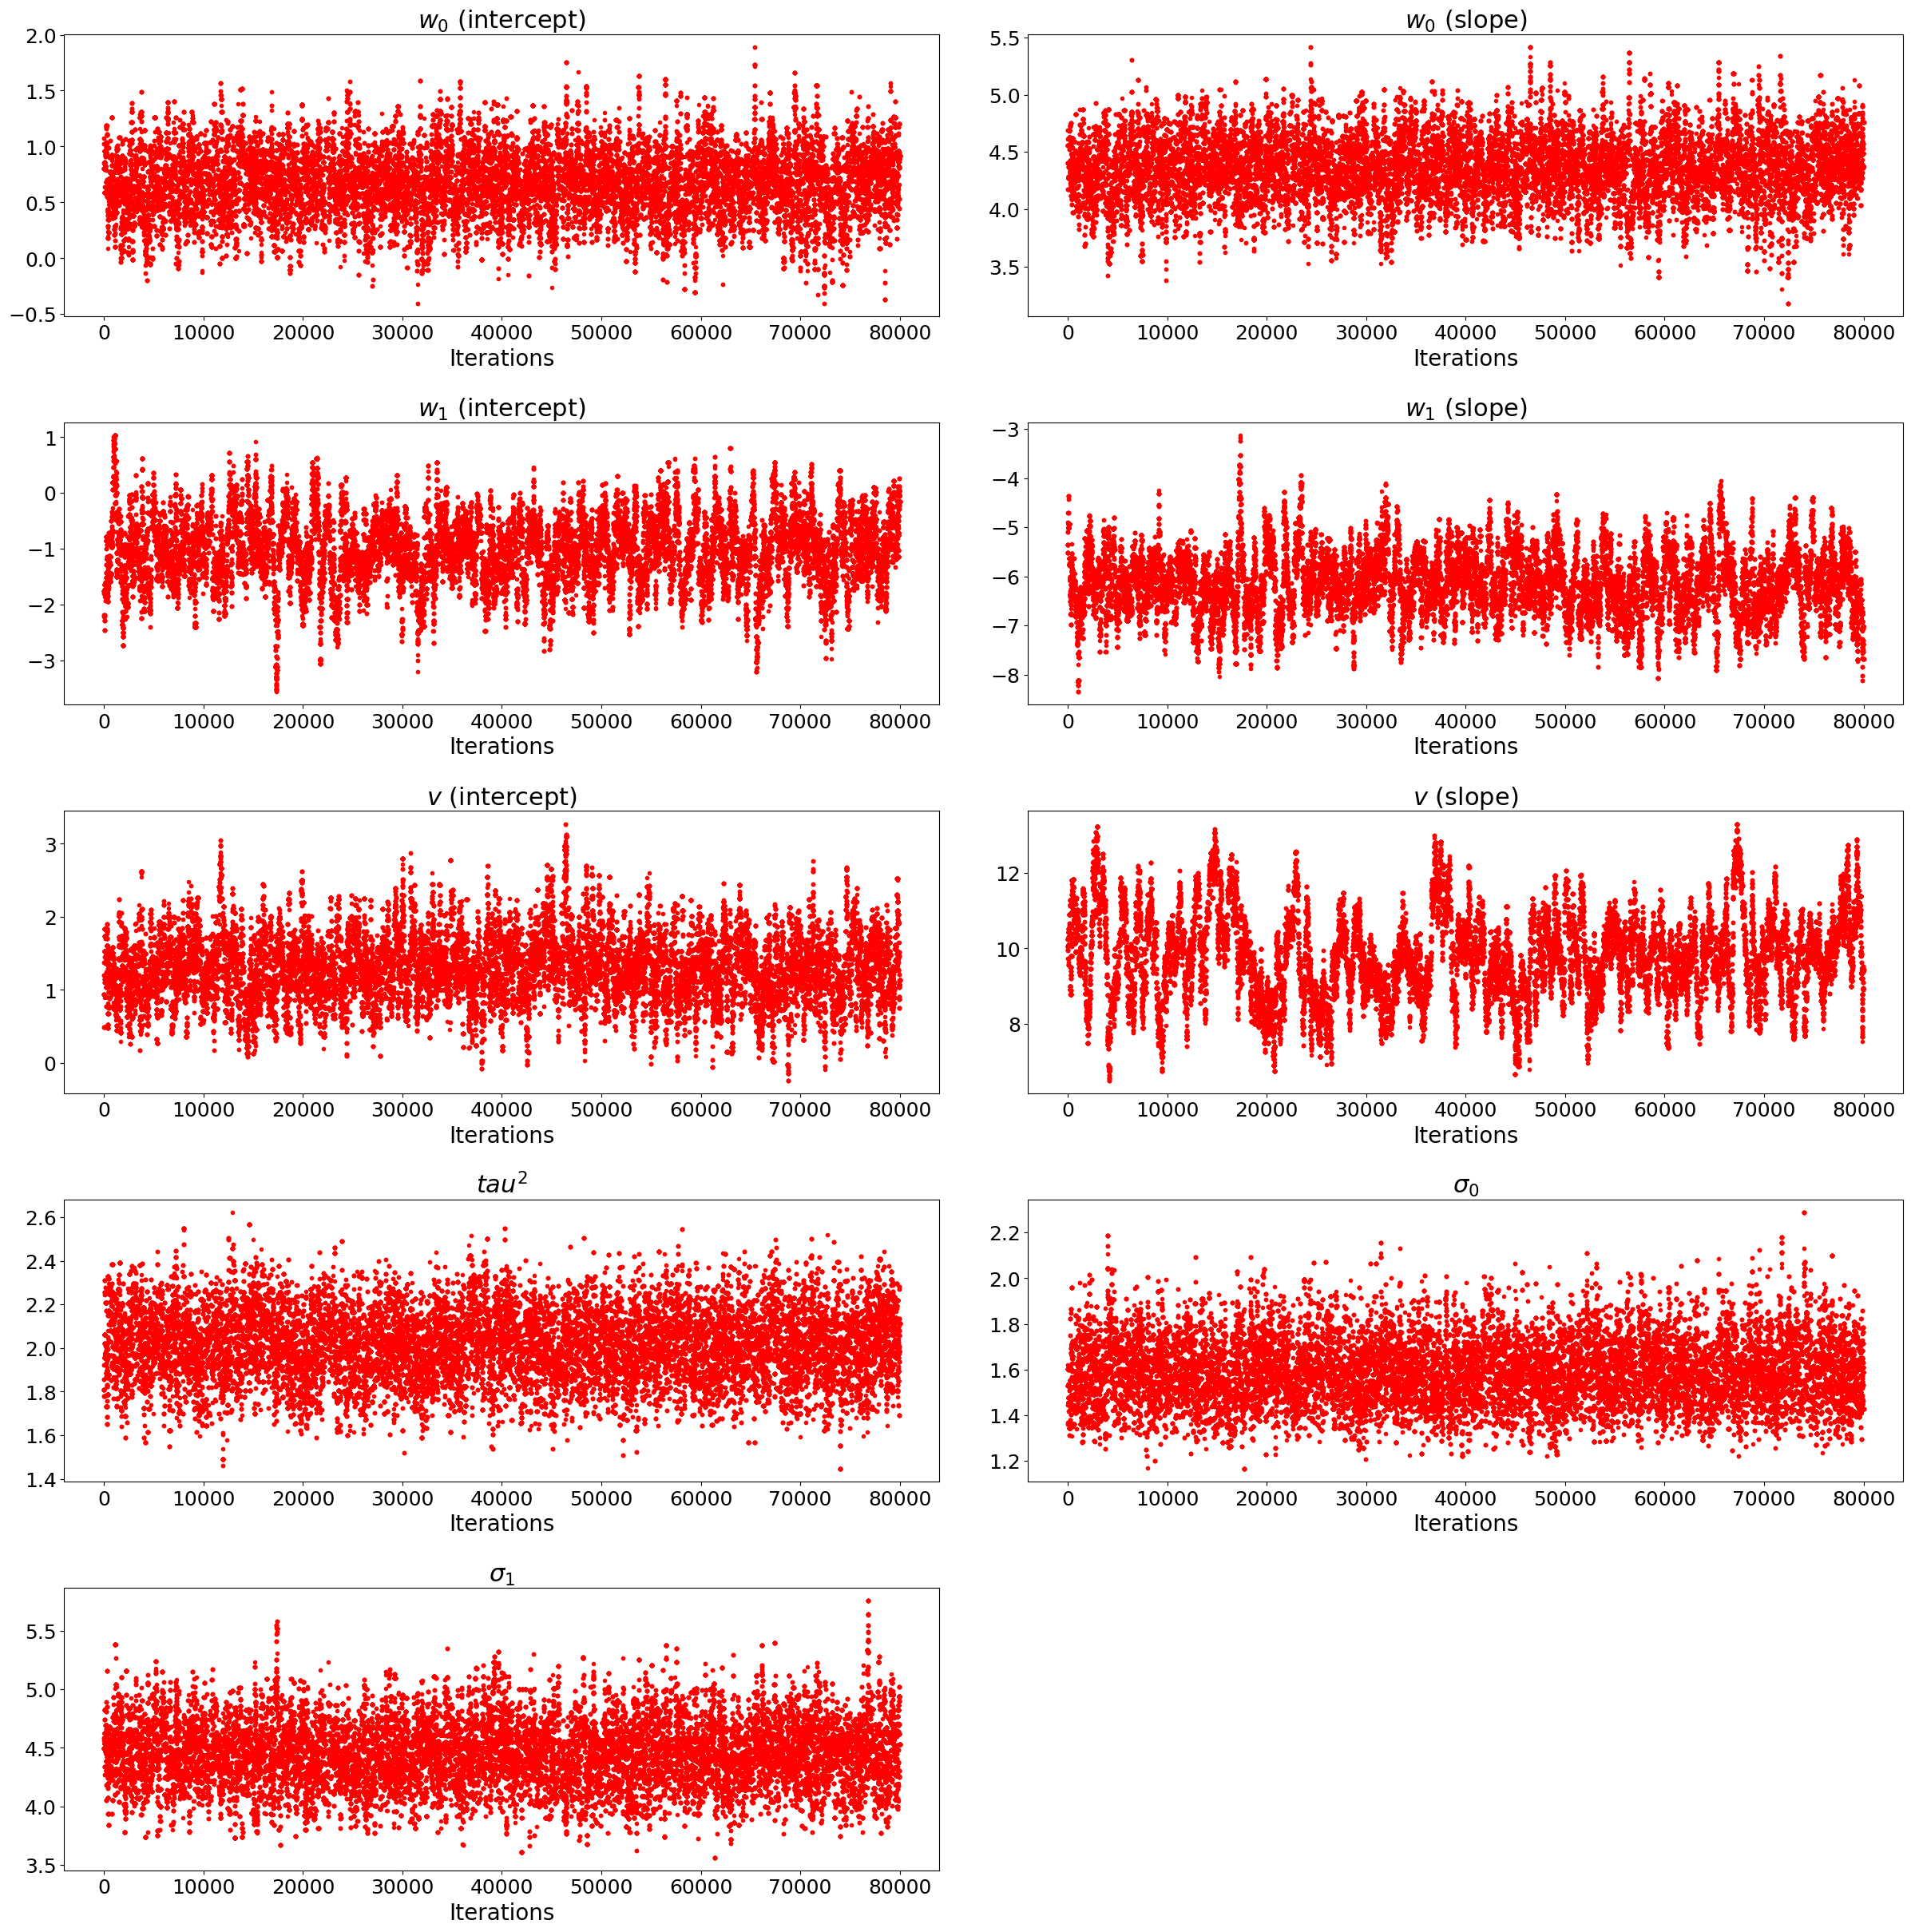

In [388]:
# 2.3
w_0 = mixture_reg[:, 0:2]
w_1 = mixture_reg[:, 2:4]
v = mixture_reg[:, 4:6]

tau_sqr = mixture_reg[:, 6]
sigma_0 = mixture_reg[:, 7]
sigma_1 = mixture_reg[:, 8]


fig, axes = plt.subplots(5, 2, figsize=(25, 25))
axes[0,0].plot(w_0[:, 0], 'r.')
axes[0,0].set_title('$w_0$ (intercept)', fontsize=22)

axes[0,1].plot(w_0[:, 1], 'r.')
axes[0,1].set_title('$w_0$ (slope)', fontsize=22)

axes[1,0].plot(w_1[:, 0], 'r.')
axes[1,0].set_title('$w_1$ (intercept)', fontsize=22)

axes[1,1].plot(w_1[:, 1], 'r.')
axes[1,1].set_title('$w_1$ (slope)', fontsize=22)

axes[2,0].plot(v[:, 0], 'r.')
axes[2,0].set_title('$v$ (intercept)', fontsize=22)

axes[2,1].plot(v[:, 1], 'r.')
axes[2,1].set_title('$v$ (slope)', fontsize=22)

axes[3,0].plot(tau_sqr, 'r.')
axes[3,0].set_title('$tau^2$', fontsize=22)

axes[3,1].plot(sigma_0, 'r.')
axes[3,1].set_title('$\sigma_0$', fontsize=22)

axes[4,0].plot(sigma_1, 'r.')
axes[4,0].set_title('$\sigma_1$', fontsize=22)

fig.delaxes(axes[4,1])


fig.tight_layout(pad=5.0)

for i in range(5):
    for j in range(2):
        if (i == 5) & (j == 2):
            break
        axes[i, j].set_xlabel('Iterations')
        axes[i, j].tick_params(labelsize=18)
        axes[i, j].xaxis.label.set_size(20)


    
mu_w0 = np.mean(w_0, axis=0)
mu_w1 = np.mean(w_1, axis=0)
mu_v = np.mean(v, axis=0)

fig.savefig('foo.png', bbox_inches='tight')

def function_est(data):
    t = []
    for x in data:
        if sigmoid(x@mu_v) < 0.5:
            t.append(x@mu_w0)
        else:
            t.append(x@mu_w1)
    return t
pred = function_est(X_train)

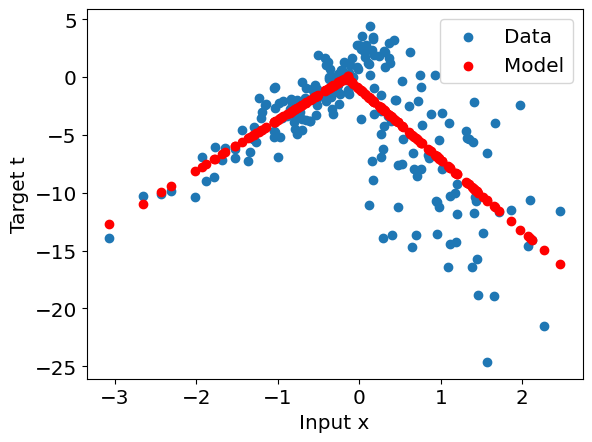

In [389]:
import matplotlib.pyplot as plt
plt.scatter(X, t_train)
plt.scatter(X, pred, color="r")
plt.xlabel("Input x")
plt.ylabel("Target t")
plt.legend(["Data", "Model"])
plt.savefig('foo1.png')

plt.show()


In [396]:
# 2.4
print("Posterior mean for w_0 intercept " + str(round(np.mean(w_0[:, 0]), 3)))
print("Posterior mean for w_0 slope " +  str(round(np.mean(w_0[:, 1]), 3)))

interval_w0_intercept = np.percentile(w_0[:, 0], [2.5, 97.5])
interval_w0_slope = np.percentile(w_0[:, 1], [2.5, 97.5])
print(f'95% credibility interval for w_0 intercept: [{interval_w0_intercept[0]:4.3f}, {interval_w0_intercept[1]:4.3f}] (estimated using sampling)')
print(f'95% credibility interval for w_0 slope: [{interval_w0_slope[0]:4.3f}, {interval_w0_slope[1]:4.3f}] (estimated using sampling)')

print("Posterior mean for w_1 intercept " + str(round(np.mean(w_1[:, 0]), 3)))
print("Posterior mean for w_1 slope " +  str(round(np.mean(w_1[:, 1]), 3)))

interval_w1_intercept = np.percentile(w_1[:, 0], [2.5, 97.5])
interval_w1_slope = np.percentile(w_1[:, 1], [2.5, 97.5])
print(f'95% credibility interval for w_1 intercept: [{interval_w1_intercept[0]:4.3f}, {interval_w1_intercept[1]:4.3f}] (estimated using sampling)')
print(f'95% credibility interval for w_1 slope: [{interval_w1_slope[0]:4.3f}, {interval_w1_slope[1]:4.3f}] (estimated using sampling)')

print("Posterior mean for v intercept " + str(round(np.mean(v[:, 0]), 3)))
print("Posterior mean for v slope " +  str(round(np.mean(v[:, 1]), 3)))

interval_v_intercept = np.percentile(v[:, 0], [2.5, 97.5])
interval_v_slope = np.percentile(v[:, 1], [2.5, 97.5])
print(f'95% credibility interval for v intercept: [{interval_v_intercept[0]:4.3f}, {interval_v_intercept[1]:4.3f}] (estimated using sampling)')
print(f'95% credibility interval for v slope: [{interval_v_slope[0]:4.3f}, {interval_v_slope[1]:4.3f}] (estimated using sampling)')
print("Posterior mean for tau square " + str(round(np.mean(tau_sqr), 3)))
print("Posterior mean for sigma 0 " +  str(round(np.mean(sigma_0), 3)))
interval_tau_sqr = np.percentile(np.abs(tau_sqr), [2.5, 97.5])
print(f'95% credibility interval for tau square: [{interval_tau_sqr[0]:4.3f}, {interval_tau_sqr[1]:4.3f}] (estimated using sampling)')
print("Posterior mean for sigma 0 " +  str(round(np.mean(sigma_0), 3)))
interval_sigma_0 = np.percentile(np.abs(sigma_0), [2.5, 97.5])
print(f'95% credibility interval for sigma 0: [{interval_sigma_0[0]:4.3f}, {interval_sigma_0[1]:4.3f}] (estimated using sampling)')
print("Posterior mean for sigma 1 " + str(round(np.mean(sigma_1), 3)))
interval_sigma_1 = np.percentile(np.abs(sigma_1), [2.5, 97.5])
print(f'95% credibility interval for sigma 1: [{interval_sigma_1[0]:4.3f}, {interval_sigma_1[1]:4.3f}] (estimated using sampling)')

Posterior mean for w_0 intercept 0.672
Posterior mean for w_0 slope 4.36
95% credibility interval for w_0 intercept: [0.110, 1.240] (estimated using sampling)
95% credibility interval for w_0 slope: [3.811, 4.883] (estimated using sampling)
Posterior mean for w_1 intercept -1.016
Posterior mean for w_1 slope -6.145
95% credibility interval for w_1 intercept: [-2.251, 0.161] (estimated using sampling)
95% credibility interval for w_1 slope: [-7.338, -4.886] (estimated using sampling)
Posterior mean for v intercept 1.301
Posterior mean for v slope 9.809
95% credibility interval for v intercept: [0.457, 2.248] (estimated using sampling)
95% credibility interval for v slope: [7.711, 12.202] (estimated using sampling)
Posterior mean for tau square 2.018
Posterior mean for sigma 0 1.582
95% credibility interval for tau square: [1.725, 2.301] (estimated using sampling)
Posterior mean for sigma 0 1.582
95% credibility interval for sigma 0: [1.346, 1.860] (estimated using sampling)
Posterior me

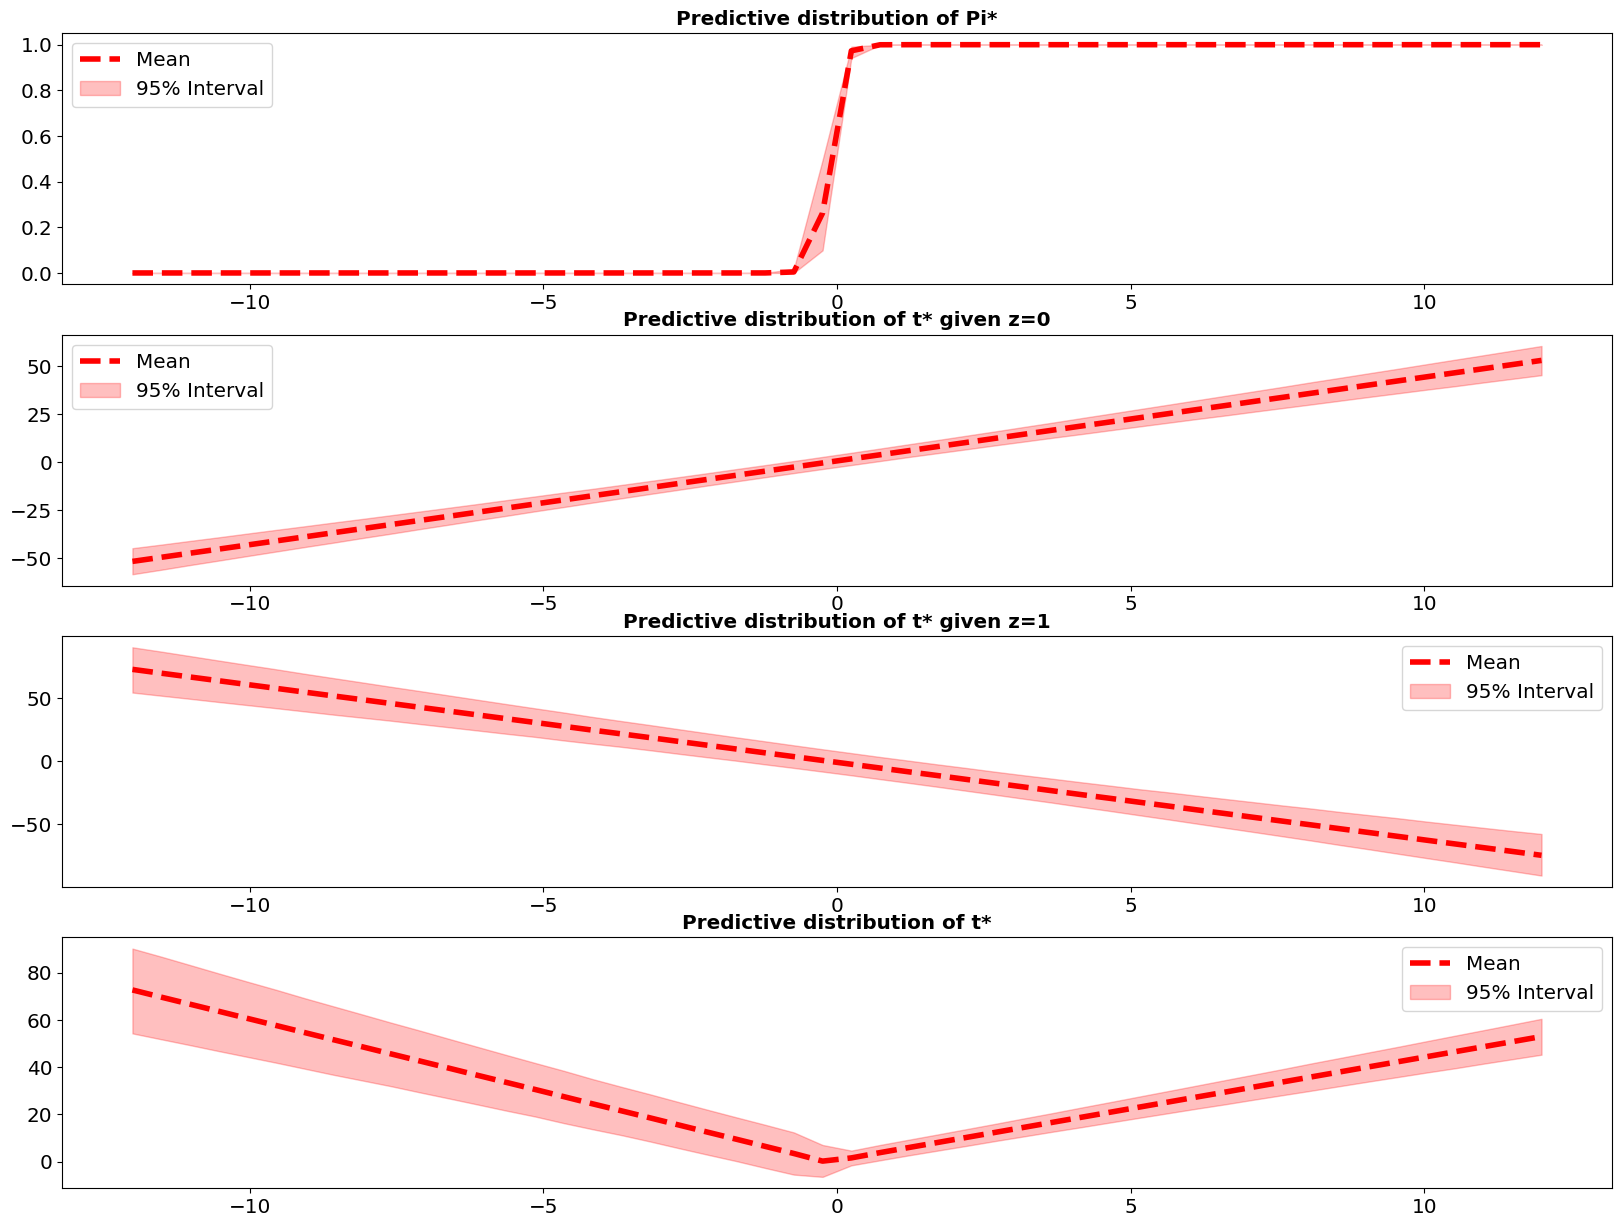

In [397]:
# 2.5 and 2.6
from exercise8 import plot_summary

# plot
fig, axes = plt.subplots(4, 1, figsize=(20, 15))
x_axis = np.linspace(-12,12)
X_train_samples = x_axis[:, None]
# Let's set-up the design matrix for the training data and the inputs for predictions
X_train_samples = design_matrix(X_train_samples)

predictive_pi = []
predictive_t_z_0 = []
predictive_t_z_1 = []
predictive_t = []

for w_0_it, w_1_it, v_it, tau_sqr_it, sigma_0_it, sigma_1_it in zip(w_0, w_1, v, tau_sqr, sigma_0, sigma_1):
    pi = sigmoid(X_train_samples @ v_it)
    
    t_z_0 = np.random.normal(X_train_samples@w_0_it, np.abs(sigma_0_it))
    
    t_z_1 = np.random.normal(X_train_samples@w_1_it, np.abs(sigma_1_it))
    
    t = (t_z_0 * pi) + (t_z_1 * (1-pi))

    predictive_pi.append(pi)
    predictive_t_z_0.append(t_z_0)
    predictive_t_z_1.append(t_z_1)
    predictive_t.append(t)
    
    
# compute probability

    
plot_summary(axes[0], x_axis, predictive_pi, num_samples=0, title='Predictive distribution of Pi*')
plot_summary(axes[1], x_axis, predictive_t_z_0, num_samples=0, title='Predictive distribution of t* given z=0')
plot_summary(axes[2], x_axis, predictive_t_z_1, num_samples=0, title='Predictive distribution of t* given z=1')
plot_summary(axes[3], x_axis, predictive_t, num_samples=0, title='Predictive distribution of t*')



In [302]:
# 2.8

Probably a Categorial distribution in the middle (Categorical[softmax(𝐲𝑛)] - task 6!)

SyntaxError: invalid syntax (3759813082.py, line 3)